# Intro to keras as part of Tensorflow
    - Load MNIST dataset
    - Linear model
    - Neural model
    - Convolutional model

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


/Users/jorge/anaconda3/envs/tm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version:  1.7.0


In [2]:
# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3848434950671106514
]


## Get some data

In [3]:
# Import mnist dataset and rescale between [0,1]

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X train shape: ',X_train.shape)
print('y train shape: ',y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (60000, 28, 28)
y train shape:  (60000,)
X test shape:  (10000, 28, 28)
y test shape:  (10000,)


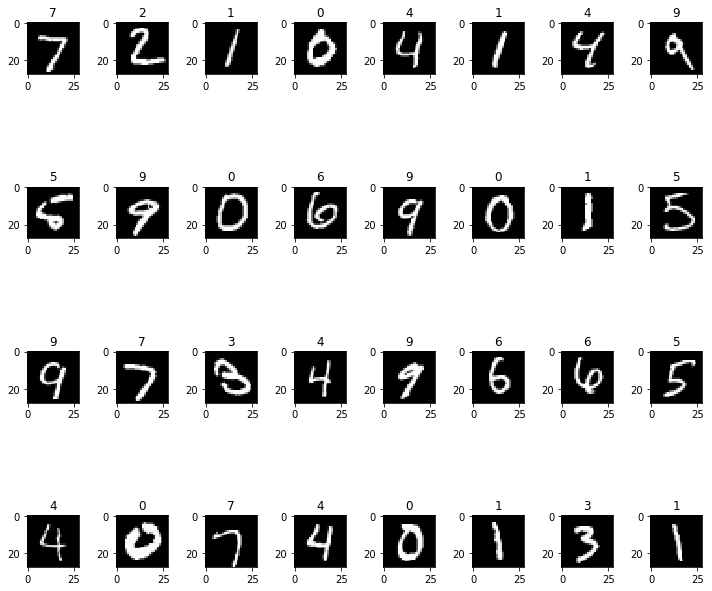

In [4]:
#Examine the data
plt.rcParams['figure.figsize'] = (10, 10)

fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_test[i]))
    fig.tight_layout()
    plt.imshow(X_test[i])
    

## Linear model

In [5]:
print('Linear model...')
images = tf.keras.layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat = tf.keras.layers.Flatten(name='Flat_image')(images)
output = tf.keras.layers.Dense(10, activation='softmax', name='Dense_output')(flat)

# Model Architecture defined
model_linear = tf.keras.models.Model(inputs=images, outputs=output)
model_linear.summary()


Linear model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_output (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Select optimizer and compile model
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.01)
model_linear.compile(loss='sparse_categorical_crossentropy', 
                     optimizer=sgd_optimizer, metrics=['accuracy'])

In [7]:
# Train the model
start = time.time()

tb_callback_ln = tf.keras.callbacks.TensorBoard(log_dir='../data/tensorboard/keras/linear/')

history_linear = model_linear.fit(X_train, y_train, batch_size=128, epochs=50,
                                  verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_ln])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 12us/step - loss: 1.2732 - acc: 0.6965 - val_loss: 0.8116 - val_acc: 0.8270
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.7191 - acc: 0.8382 - val_loss: 0.6089 - val_acc: 0.8595
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5896 - acc: 0.8583 - val_loss: 0.5268 - val_acc: 0.8724
Epoch 4/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.5271 - acc: 0.8682 - val_loss: 0.4810 - val_acc: 0.8805
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.4890 - acc: 0.8753 - val_loss: 0.4509 - val_acc: 0.8832
Epoch 6/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.4627 - acc: 0.8801 - val_loss: 0.4295 - val_acc: 0.8884
Epoch 7/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.4433 - acc: 0.8834 - val_loss: 0.4129 - val_acc

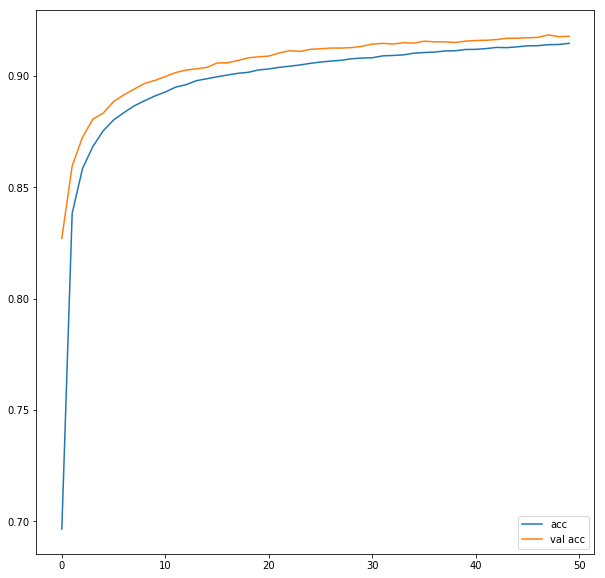

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.plot(history_linear.history['acc'], label='acc')
plt.plot(history_linear.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Score and select prediction with max prob
import numpy as np
p_test = model_linear.predict(X_test)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,pred_test))

[[ 960    0    2    2    0    3   10    1    2    0]
 [   0 1105    2    2    0    2    4    2   18    0]
 [   9    8  909   15   13    1   14   15   40    8]
 [   3    1   24  919    0   23    2   10   19    9]
 [   1    1    5    2  913    0   13    2    9   36]
 [  11    4    3   38   11  763   17    6   31    8]
 [  10    3    4    1   12   12  914    1    1    0]
 [   3   11   23    8    7    0    0  937    3   36]
 [   7   10    6   23    9   23   12   14  860   10]
 [  11    7    3   12   42    7    0   24    6  897]]


## Neural network model 

In [10]:
print('NN model...')

images = tf.keras.layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat   = tf.keras.layers.Flatten(name='Flat_image')(images)
dense  = tf.keras.layers.Dense(500, activation='relu', name='Dense_layer')(flat)
output = tf.keras.layers.Dense(10, activation='softmax', name='Dense_output')(dense)

# Model Architecture defined
model_nn = tf.keras.models.Model(inputs=images, outputs=output)
model_nn.summary()


NN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 500)               392500    
_________________________________________________________________
Dense_output (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [11]:
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.01)
model_nn.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=sgd_optimizer, metrics=['accuracy'])


In [12]:
# Train the model
start = time.time()

tb_callback_nn = tf.keras.callbacks.TensorBoard(log_dir='../data/tensorboard/keras/neural/')

history_nn = model_nn.fit(X_train, y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_nn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/step - loss: 1.1010 - acc: 0.7580 - val_loss: 0.6033 - val_acc: 0.8673
Epoch 2/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.5249 - acc: 0.8708 - val_loss: 0.4365 - val_acc: 0.8902
Epoch 3/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.4227 - acc: 0.8889 - val_loss: 0.3754 - val_acc: 0.9021
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3757 - acc: 0.8981 - val_loss: 0.3421 - val_acc: 0.9088
Epoch 5/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.3468 - acc: 0.9051 - val_loss: 0.3199 - val_acc: 0.9136
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.3264 - acc: 0.9091 - val_loss: 0.3041 - val_acc: 0.9159
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3104 - acc: 0.9139 - val_loss: 0.2902 - val_acc

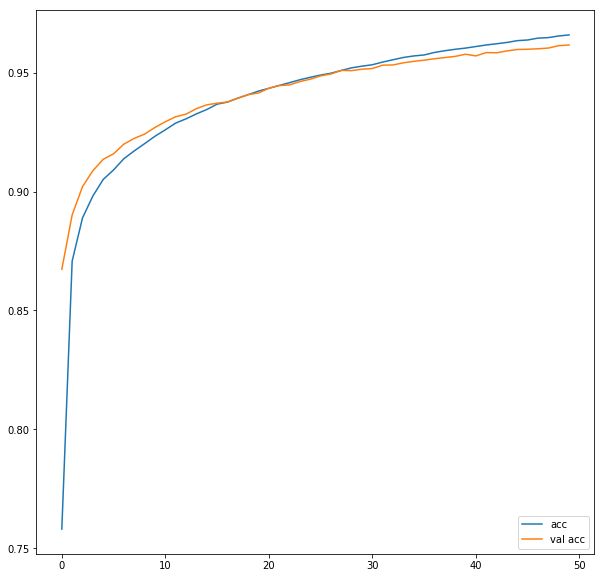

In [13]:
# Plot train vs valid
plt.rcParams['figure.figsize'] = (10, 10)

plt.plot(history_nn.history['acc'], label='acc')
plt.plot(history_nn.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

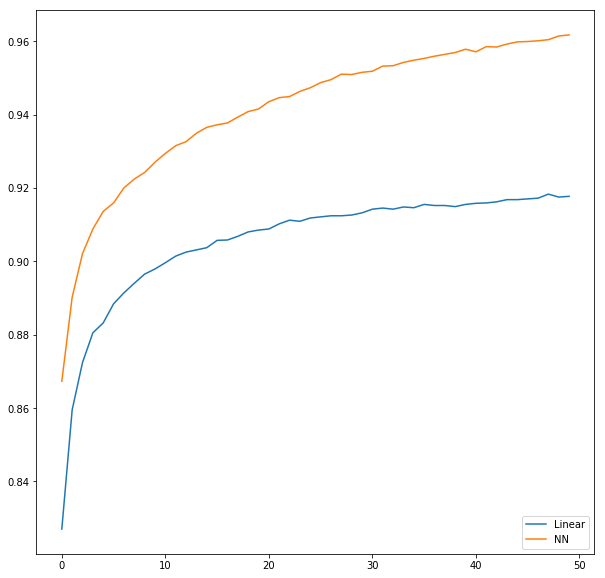

In [14]:
# Compare the two models
plt.rcParams['figure.figsize'] = (10, 10)

plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.legend(loc='lower right')
plt.show()

## Convolutional model

In [15]:
#Define the model
print('Convolutional model...')
print('LeNet architecture.')

#Inputs
images = tf.keras.layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = tf.keras.layers.Conv2D(20, (5,5))(images)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = tf.keras.layers.Conv2D(20, (5,5))(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = tf.keras.layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = tf.keras.layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = tf.keras.layers.Dense(10, activation='softmax', name='Dense_output')(dense1)

# Model Architecture defined
model_conv = tf.keras.models.Model(inputs=images, outputs=output)
model_conv.summary()


Convolutional model...
LeNet architecture.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (Non

In [16]:
# Compile model and select optimizer
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [17]:
# Train the model
X_train_img = X_train.reshape(X_train.shape[0], 28, 28, 1) 
X_test_img = X_test.reshape(X_test.shape[0], 28, 28, 1)

start = time.time()

tb_callback_cnn = tf.keras.callbacks.TensorBoard(log_dir='../data/tensorboard/keras/CNN/')

history = model_conv.fit(X_train_img, y_train, batch_size=128, epochs=10,
                    verbose=1, validation_data=(X_test_img, y_test), callbacks=[tb_callback_cnn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s 361us/step - loss: 0.3188 - acc: 0.9185 - val_loss: 0.0627 - val_acc: 0.9818
Epoch 2/10
60000/60000 [==============================] - 21s 352us/step - loss: 0.0535 - acc: 0.9848 - val_loss: 0.0394 - val_acc: 0.9878
Epoch 3/10
60000/60000 [==============================] - 21s 352us/step - loss: 0.0295 - acc: 0.9907 - val_loss: 0.0429 - val_acc: 0.9875
Epoch 4/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0334 - val_acc: 0.9894
Epoch 5/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0351 - val_acc: 0.9895
Epoch 6/10
60000/60000 [==============================] - 22s 370us/step - loss: 0.0110 - acc: 0.9970 - val_loss: 0.0339 - val_acc: 0.9899
Epoch 7/10
60000/60000 [==============================] - 22s 360us/step - loss: 0.0091 - acc: 0.9975 - val_loss: 0.

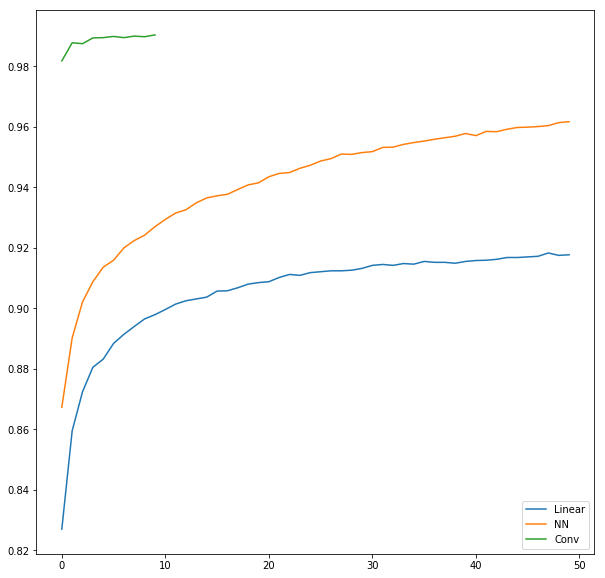

In [18]:
#Compare with previous
plt.rcParams['figure.figsize'] = (10, 10)

plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.plot(history.history['val_acc'], label='Conv')
plt.legend(loc='lower right')
plt.show()


In [19]:
# Score and select prediction with max prob
import numpy as np
p_test = model_conv.predict(X_test_img)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_test))

[[ 973    0    1    0    0    0    3    1    2    0]
 [   0 1125    2    3    0    2    2    0    1    0]
 [   2    2 1023    0    1    0    1    2    1    0]
 [   0    0    2 1003    0    4    0    1    0    0]
 [   0    0    0    0  973    0    4    1    0    4]
 [   1    0    0    5    0  884    1    1    0    0]
 [   3    2    0    0    2    3  947    0    1    0]
 [   0    3    2    0    0    0    0 1020    1    2]
 [   2    0    1    3    0    2    0    1  964    1]
 [   0    0    0    2    5    1    1    5    3  992]]


n:  1 - Pred 1: 6(0.584) - Pred 2: 2(0.413)
n:  2 - Pred 1: 5(0.998) - Pred 2: 3(0.002)
n:  3 - Pred 1: 3(0.488) - Pred 2: 2(0.330)
n:  4 - Pred 1: 8(0.569) - Pred 2: 2(0.250)
n:  5 - Pred 1: 1(0.461) - Pred 2: 7(0.268)
n:  6 - Pred 1: 9(0.618) - Pred 2: 4(0.382)
n:  7 - Pred 1: 8(0.989) - Pred 2: 9(0.011)
n:  8 - Pred 1: 3(0.930) - Pred 2: 1(0.070)
n:  9 - Pred 1: 5(0.634) - Pred 2: 3(0.366)
n: 10 - Pred 1: 9(0.820) - Pred 2: 8(0.179)
n: 11 - Pred 1: 5(0.846) - Pred 2: 6(0.146)
n: 12 - Pred 1: 1(0.949) - Pred 2: 4(0.026)
n: 13 - Pred 1: 6(0.966) - Pred 2: 4(0.033)
n: 14 - Pred 1: 1(0.582) - Pred 2: 2(0.418)
n: 15 - Pred 1: 5(0.941) - Pred 2: 6(0.057)
n: 16 - Pred 1: 4(0.577) - Pred 2: 2(0.423)
n: 17 - Pred 1: 4(0.967) - Pred 2: 9(0.024)
n: 18 - Pred 1: 9(0.905) - Pred 2: 4(0.095)
n: 19 - Pred 1: 1(0.795) - Pred 2: 7(0.202)
n: 20 - Pred 1: 7(0.971) - Pred 2: 5(0.024)
n: 21 - Pred 1: 3(0.517) - Pred 2: 8(0.223)
n: 22 - Pred 1: 3(0.948) - Pred 2: 5(0.052)
n: 23 - Pred 1: 5(0.848) - Pred 

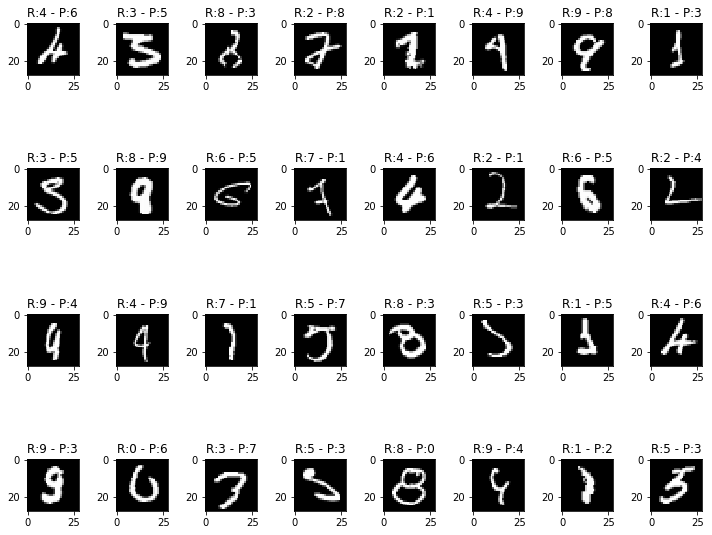

In [20]:

#Print probabilities to the first erros
test_errors=[]
test_errors_real=[]
test_errors_predict=[]
num_errors = 32
n = 0
for i in range(len(pred_test)):
    if pred_test[i] != y_test[i] and n < num_errors: #Error!
        n += 1
        test_errors += [X_test_img[i,:,:,0]]
        test_errors_real += [y_test[i]]
        test_errors_predict += [pred_test[i]]
        
        #Print first propabilities
        index = p_test[i].argsort()[::-1]
        print('n: %2i - Pred 1: %1i(%0.3f) - Pred 2: %1i(%0.3f)' % (n,
              index[0], p_test[i][index[0]], index[1], p_test[i][index[1]]))
        
print("Num errors: ", len(test_errors))


#Plot 32 images wrong classified.
plt.rcParams['figure.figsize'] = (10, 10)

fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(5, 8, n+1)
    a.set_title('R:'+str(test_errors_real[i])+' - P:'+str(test_errors_predict[i]))
    fig.tight_layout()
    plt.imshow(test_errors[i])
    

# Input batch example
    - Define a batch generator
    - Use it in the train process

In [21]:
# New model. Equal to the last.
model_conv2 = tf.keras.models.Model(inputs=images, outputs=output)

sgd_optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [22]:
# Define a generator to X_train. Same code to an HDF5 source
def batch_generator(X, y, batch_size=64):
    data_size = X.shape[0]
    while 1:
        # Randomize batches in each epoch
        batch_randomized = np.random.permutation(range(0, data_size-batch_size, batch_size))
        # Iterate over each batch
        for batch in batch_randomized:
            x_batch = X[batch : batch+batch_size]
            y_batch = y[batch : batch+batch_size]
            yield x_batch, y_batch

In [23]:
#Test the generator
seq = batch_generator(X_train_img, y_train)    
next_seq = next(seq)
print(next_seq[0][0].shape)
print(next_seq[1])


(28, 28, 1)
[1 4 9 8 9 9 4 6 3 4 7 6 4 5 4 0 1 2 6 1 6 0 8 5 2 0 7 1 2 1 5 7 1 8 5 4 2
 3 8 2 4 7 4 9 1 3 9 9 3 0 3 1 3 2 6 3 2 4 5 5 4 7 7 8]


In [24]:
# Train using the fit_generator function

# Number of steps to use all the train data in a epoch.
steps = X_train.shape[0]//64

history = model_conv2.fit_generator(batch_generator(X_train_img, y_train, batch_size=64),
                                    steps_per_epoch=steps, epochs=10,
                                    verbose=1, validation_data=(X_test_img, y_test))


Epoch 1/10
937/937 [==============================] - 21s 22ms/step - loss: 0.1004 - acc: 0.9748 - val_loss: 0.0721 - val_acc: 0.9805
Epoch 2/10
937/937 [==============================] - 22s 24ms/step - loss: 0.0317 - acc: 0.9901 - val_loss: 0.0350 - val_acc: 0.9893
Epoch 3/10
937/937 [==============================] - 21s 23ms/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0329 - val_acc: 0.9911
Epoch 4/10
937/937 [==============================] - 25s 27ms/step - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0347 - val_acc: 0.9909
Epoch 5/10
937/937 [==============================] - 25s 27ms/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0366 - val_acc: 0.9899
Epoch 6/10
937/937 [==============================] - 23s 25ms/step - loss: 0.0050 - acc: 0.9990 - val_loss: 0.0357 - val_acc: 0.9913
Epoch 7/10
937/937 [==============================] - 23s 25ms/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.0366 - val_acc: 0.9915
Epoch 8/10
937/937 [==============================] - 25s 27ms